2023-11-02 01:29:31.703244: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-02 01:29:31.704724: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-02 01:29:31.726034: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-02 01:29:31.726059: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-02 01:29:31.726074: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

downloading images
images are stored in /home/patrick/.keras/datasets/flower_photos
there are 3670 images
Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
0.0 1.0
92/92 [==============================] - 16s 170ms/step - loss: 1.2551 - accuracy: 0.4663 - val_loss: 1.0173 - val_accuracy: 0.5967


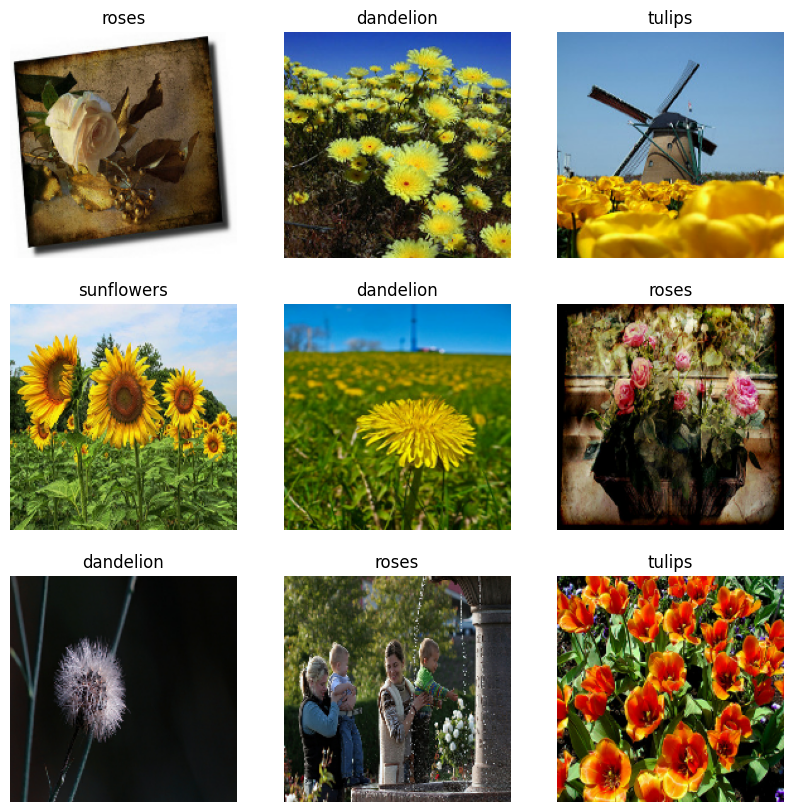

In [1]:
# this cell contains code to build the flower
# source https://www.tensorflow.org/tutorials/load_data/images
import pathlib
import random
import os

import tensorflow as tf
import numpy as np
import IPython.display as display

tf.__version__


print("downloading images")
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix("")

print("images are stored in {}".format(data_dir))
image_count = len(list(data_dir.glob("*/*.jpg")))
print("there are {} images".format(image_count))

batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

class_names = train_ds.class_names
print(class_names)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

num_classes = 5

model = tf.keras.Sequential(
    [
        tf.keras.layers.Rescaling(1.0 / 255),
        tf.keras.layers.Conv2D(32, 3, activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(num_classes),
    ]
)

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

model.fit(train_ds, validation_data=val_ds, epochs=1)

In [2]:
os.environ["OMEGA_FRAMEWORKS"] = "scikit-learn,tensorflow,keras"

# deploy the fitted model to omega-ml
import numpy as np
import omegaml as om

om.models.put(model, "tfkeras-flower")

/home/patrick/mambaforge/envs/omegaml-ce/lib/python3.10/site-packages/celery/fixups/django.py:56: FixupWarning: Environment variable DJANGO_SETTINGS_MODULE is defined
but Django isn't installed.  Won't apply Django fix-ups!

  warnings.warn(FixupWarning(ERR_NOT_INSTALLED))
/home/patrick/mambaforge/envs/omegaml-ce/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<Metadata: Metadata(name=tfkeras-flower,bucket=omegaml,prefix=models/,kind=tfkeras.h5,created=2023-11-02 00:02:23.093000)>

In [3]:
images_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=1,
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


1/1 [==============================] - 0s 12ms/step


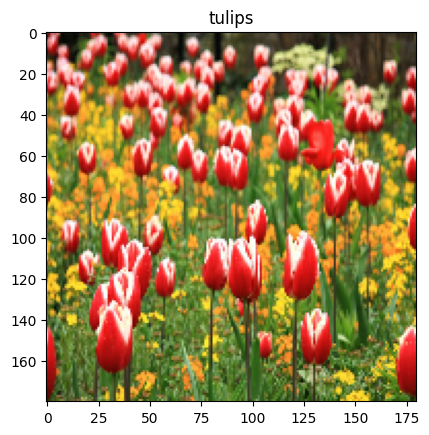

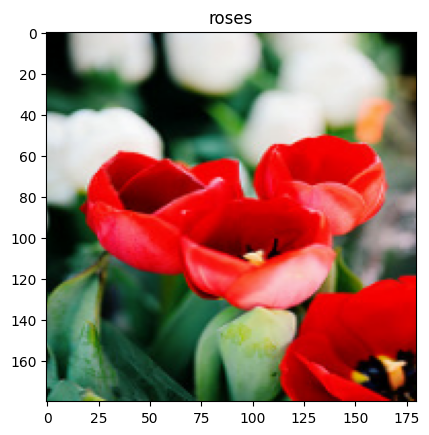

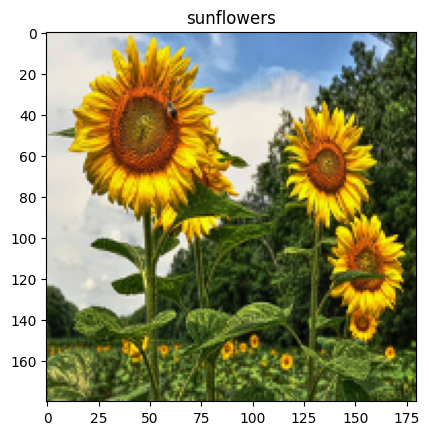

In [4]:
# use the model for prediction (Python API)
%matplotlib inline
from matplotlib import pyplot as plt

# loading the model can take some time
model_ = om.models.get("tfkeras-flower")

for img, label in images_ds.take(3):
    result = model.predict(img.numpy())
    predicted = class_names[np.argmax(result)]
    fig = plt.figure()
    plt.imshow(img[0].numpy().astype("uint8"))
    plt.title(predicted)

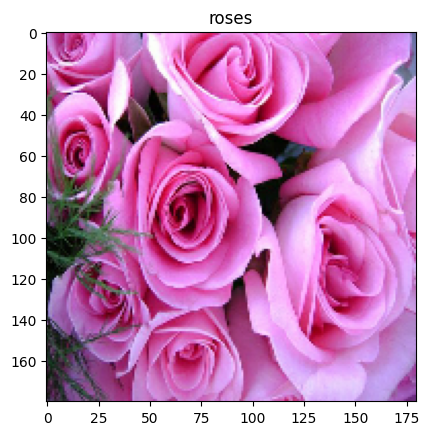

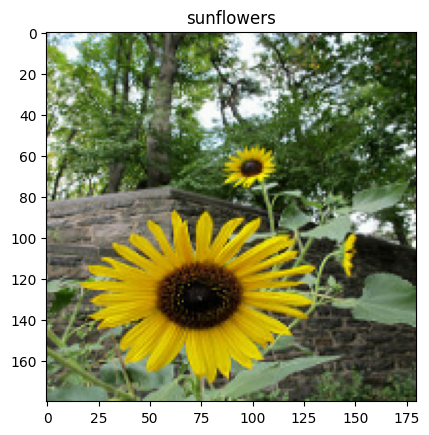

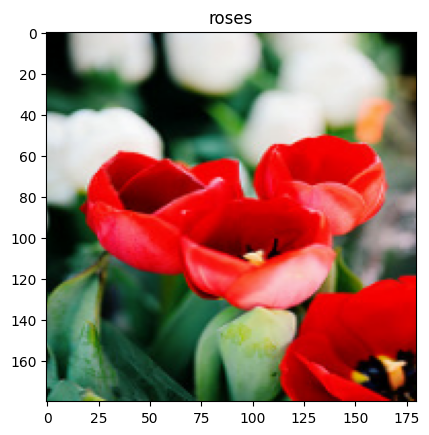

In [5]:
# start async prediction
results = []
for img, label in images_ds.take(3):
    result = om.runtime.model("tfkeras-flower").predict(np.array(img.numpy()))
    results.append((img, result))

# get results and show
for img, result in results:
    preds = result.get()
    for i, simg in enumerate(img):
        if i > 3:
            break
        pred = preds[i]
        label = class_names[np.argmax(pred)]
        fig = plt.figure()
        plt.title(label)
        plt.imshow(img[i].numpy().astype("uint8"))

{'model': 'tfkeras-flower', 'result': [-0.9053046107292175, -4.508581161499023, 6.180307388305664, -3.5794825553894043, 4.664541721343994], 'resource_uri': 'tfkeras-flower'}


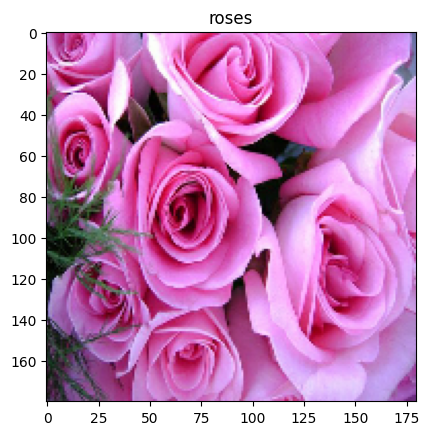

In [6]:
# REST API

%load_ext autoreload
%autoreload 2

import requests
from omegaml.client.auth import AuthenticationEnv

# -- setup authentication and API URL
auth = AuthenticationEnv.get_restapi_auth(om=om)
base_url = getattr(om.defaults, "OMEGA_RESTAPI_URL", "http://localhost:5000")

predict_url = "{base_url}/api/v1/model/tfkeras-flower/predict".format(**locals())

for img, label in images_ds.take(1):
    for i, simg in enumerate(img):
        if i > 3:
            break
        # take picture
        imgdata = img[i].numpy()
        # predict
        resp = requests.put(
            predict_url,
            json={
                "columns": ["x"],
                "data": {"x": [imgdata.tolist()]},
                "shape": list(imgdata.shape),
            },
            auth=auth,
        )
        # show result
        data = resp.json()
        print(data)
        prediction = data["result"]
        label = class_names[np.argmax(prediction)]
        fig = plt.figure()
        plt.title(label)
        plt.imshow(imgdata.astype("uint8"))

In [7]:
# save model  as a a Tensorflow SavedModel
# -- note this may print several tensorflow warnings due to deprecated functionality
model_ = om.models.get("tfkeras-flower")
om.models.put(model_, "tfkeras-flower-savedmodel", as_savedmodel=True)

<Metadata: Metadata(name=tfkeras-flower-savedmodel,bucket=omegaml,prefix=models/,kind=tfkeras.savedmodel,created=2023-11-02 00:57:17.562000)>

http://localhost:5000/api/v1/model/tfkeras-flower-savedmodel/predict
{'model': 'tfkeras-flower-savedmodel', 'result': [-0.08039688318967819, 0.033009108155965805, -1.2970330715179443, 1.4101769924163818, -0.6816001534461975], 'resource_uri': 'tfkeras-flower-savedmodel'}


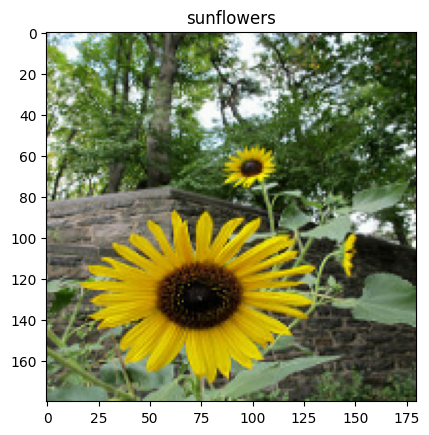

In [8]:
# use the SavedModel instance
import omegaml as om
import requests

from omegaml.client.auth import AuthenticationEnv
import omegaml as om

# -- setup authentication and API URL
auth = AuthenticationEnv.get_restapi_auth(om=om)
base_url = getattr(om.defaults, "OMEGA_RESTAPI_URL", "http://localhost:5000")
predict_url = "{base_url}/api/v1/model/tfkeras-flower-savedmodel/predict".format(
    **locals()
)

print(predict_url)

for img, label in images_ds.take(1):
    for i, simg in enumerate(img):
        if i > 3:
            break
        # take picture
        imgdata = img[i].numpy()
        # predict
        resp = requests.put(
            predict_url,
            json={
                "columns": ["x"],
                "data": {"x": [imgdata.tolist()]},
                "shape": list(imgdata.shape),
            },
            auth=auth,
        )
        # show result
        data = resp.json()
        print(data)
        prediction = data["result"]
        label = class_names[np.argmax(prediction)]
        fig = plt.figure()
        plt.title(label)
        plt.imshow(imgdata.astype("uint8"))

In [9]:
# use a virtualobj to perform business logic on model input and output
from omegaml.backends.virtualobj import virtualobj


@virtualobj
def mymodel(data=None, method=None, meta=None, store=None, **kwargs):
    # in a virutalobj handler, always import modules locally
    import numpy as np

    models = store
    if method == "predict":
        label_names = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]
        # do some pre-processing, e.g. to ensure the shape matches the model input layer
        X = np.array([data])
        # pass on to the model in required input shape
        result = models.get("tfkeras-flower-savedmodel").predict(X)
        # return labels instead of numeric result
        return label_names[np.argmax(result)]


# store an image
for img, label in images_ds.take(1):
    om.datasets.put(img[0].numpy(), "image")

# store the virtualobj handler as a model
om.models.drop("mymodel", force=True)
om.models.put(mymodel, "mymodel")

# use the model REST API using the stored image
modelname = "mymodel"
dataset = "image"
predict_url = "{base_url}/api/v1/model/{modelname}/predict?datax={dataset}".format(
    **locals()
)
resp = requests.put(predict_url, auth=auth, json={})
print(resp.json())

{'model': 'mymodel', 'result': 'tulips', 'resource_uri': 'mymodel'}


In [10]:
# store images. no need to use TFExample or TFRecord (however you can if you want to)
for i, (image, label) in enumerate(images_ds.take(10)):
    meta = om.datasets.put(image.numpy(), f"image-{i}-{label[0]}")
    print(meta)

Metadata(name=image-0-3,bucket=omegaml,prefix=data/,kind=ndarray.bin,created=2023-11-02 01:29:58.520447)
Metadata(name=image-1-2,bucket=omegaml,prefix=data/,kind=ndarray.bin,created=2023-11-02 01:29:58.525730)
Metadata(name=image-2-1,bucket=omegaml,prefix=data/,kind=ndarray.bin,created=2023-11-02 01:28:31.582000)
Metadata(name=image-3-0,bucket=omegaml,prefix=data/,kind=ndarray.bin,created=2023-11-02 01:29:58.546458)
Metadata(name=image-4-4,bucket=omegaml,prefix=data/,kind=ndarray.bin,created=2023-11-02 01:29:58.557414)
Metadata(name=image-5-1,bucket=omegaml,prefix=data/,kind=ndarray.bin,created=2023-11-02 01:29:58.569521)
Metadata(name=image-6-4,bucket=omegaml,prefix=data/,kind=ndarray.bin,created=2023-11-02 01:29:58.577566)
Metadata(name=image-7-2,bucket=omegaml,prefix=data/,kind=ndarray.bin,created=2023-11-02 01:28:31.660000)
Metadata(name=image-8-2,bucket=omegaml,prefix=data/,kind=ndarray.bin,created=2023-11-02 01:29:58.601234)
Metadata(name=image-9-2,bucket=omegaml,prefix=data/,kin

In [11]:
# virutalobj that returns a tf.Dataset
@virtualobj
def trainds(data=None, method=None, meta=None, store=None, **kwargs):
    import tensorflow as tf

    datasets = store

    def get_images():
        for name in datasets.list(regexp="image-[0-255]-.*"):
            label = name.split("-")[-1]
            img = datasets.get(name)
            yield (img, label)

    if method == "get":
        gen = get_images()
        output_types = (tf.int64, tf.int64)
        output_shapes = (tf.TensorShape([180, 180, 3]), tf.TensorShape([]))
        ds = tf.data.Dataset.from_generator(get_images, output_types, output_shapes)
        return ds.batch(32)


om.datasets.put(trainds, "tfkeras-trainds", replace=True)

<Metadata: Metadata(name=tfkeras-trainds,bucket=omegaml,prefix=data/,kind=virtualobj.dill,created=2023-11-02 01:10:48.288000)>